# DeepestLSTMTinyPilotNet prevoius speed training notebook

[WARNING] This notebook is a draft generated for training. I won't work directly

In [ ]:
!pip show tensorflow-gpu
!python3 -V
!pip show albumentations

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class DatasetSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        new_img_batch = []  
        for x, img in enumerate(batch_x):
            aug = self.augment(image=img)["image"]
            velocity_dim = np.full((150, 50), batch_y[x][3])
            new_img_vel = np.dstack((aug, velocity_dim))
            new_img_batch.append(new_img_vel)

            
        new_ann_batch = []
        for x, ann in enumerate(batch_y):
            new_ann_batch.append(np.array((ann[0], ann[1], ann[2])))
        
        a, b = np.stack(new_img_batch, axis=0), np.array(new_ann_batch)
        return a, b

In [5]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class DatasetSequenceAffine(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        new_img_batch = []  
        new_ann_batch = []
        new_batch_y = np.array(batch_y, copy=True) 
        for x, img in enumerate(batch_x):
            aug = self.augment(image=img)
            velocity_dim = np.full((150, 50), batch_y[x][3])
            new_img_vel = np.dstack((aug["image"], velocity_dim))
            new_img_batch.append(new_img_vel)
            if aug["replay"]["transforms"][0]["applied"] == True:
                x_transformation_value = aug["replay"]["transforms"][0]["translate_percent"]["x"][1]
                value = aug["replay"]["transforms"][0]["params"]["matrix"].params[0][2]
                new_value = value/10*x_transformation_value
                #new_batch_y[x][1] = new_batch_y[x][1]+new_value
                new_ann_batch.append(np.array((new_batch_y[x][0], new_batch_y[x][1]+new_value, new_batch_y[x][2])))
            else:
                new_ann_batch.append(np.array((new_batch_y[x][0], new_batch_y[x][1], new_batch_y[x][2])))
        
        new_batch_y = new_ann_batch
            

        return np.stack(new_img_batch, axis=0), np.array(new_batch_y)

In [ ]:
import glob
import os
import cv2
import pandas

import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

image_shape=(200, 66)
image_shape=(50, 150)

def get_images(folder_prefix, list_images, type_image):
    # Read the images
    array_imgs = []
    for name in list_images:
        try:
            img = cv2.imread(folder_prefix + name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_shape)
            array_imgs.append(img)
        except:
            print('ERROR in value')

    return array_imgs

def parse_csv(csv_data):
    array = []
    #print(csv_data)
    linear_speeds = csv_data['throttle'].tolist()
    angular_speeds = csv_data['steer'].tolist()
    brakes = csv_data['brake'].tolist()
    images_ids = csv_data['image_id'].tolist()
    velocity = csv_data['velocity'].tolist()
    timestamp = csv_data['timestamp'].tolist()
    for x, linear_speed in enumerate(linear_speeds):
        try:
            array.append((float(linear_speed), float(angular_speeds[x]), float(brakes[x]), float(velocity[x]), float(timestamp[x])))
        except:
            print('ERROR in value')
    return images_ids, array

def flip_images(images, array_annotations):
    flipped_images = []
    flipped_annotations = []
    for i, image in enumerate(images):
        flipped_images.append(cv2.flip(image, 1))
        flipped_annotations.append((array_annotations[i][0], -array_annotations[i][1]))
    
    images += flipped_images
    array_annotations += flipped_annotations
    return images, array_annotations

def add_extreme_data(images, array_annotations):
    
    for i in range(0, len(array_annotations)):
        if abs(array_annotations[i][1]) >= 0.1:
            if abs(array_annotations[i][1]) >= 0.3:
                num_iter = 15
                #num_iter = 10
            elif abs(array_annotations[i][1]) >= 0.2:
                num_iter = 5
            else:
                num_iter = 2
            for j in range(0, num_iter):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
        if abs(array_annotations[i][2]) >= 0.1:
            if abs(array_annotations[i][2]) >= 0.3:
                num_iter = 15
                #num_iter = 10
            elif abs(array_annotations[i][2]) >= 0.2:
                num_iter = 5
            else:
                num_iter = 2
            for j in range(0, num_iter):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
    
    return images, array_annotations

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

def normalize_v(x):
    x = np.asarray(x)
    return (x - 0) / (np.ptp(x))


########################################################################################################################### 1 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_1 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))


array_annotations_carla_dataset_1 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_1 = parse_csv(array_annotations_carla_dataset_1)

print('FPS: ', 1 / ((array_annotations_carla_dataset_1[len(array_annotations_carla_dataset_1)-1][4]-array_annotations_carla_dataset_1[0][4]) / len(array_annotations_carla_dataset_1)))


images_carla_dataset_1 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/', images_ids, 'cropped')

#images_carla_dataset, array_annotations_carla_dataset_1 = flip_images(images_carla_dataset_1, array_annotations_carla_dataset_1)
print(len(images_carla_dataset_1))
print(type(images_carla_dataset_1))
print(len(array_annotations_carla_dataset_1))
images_carla_dataset_1, array_annotations_carla_dataset_1 = add_extreme_data(images_carla_dataset_1, array_annotations_carla_dataset_1)
print(len(images_carla_dataset_1))
print(type(images_carla_dataset_1))
print(len(array_annotations_carla_dataset_1))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_1:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_1 = normalized_annotations
print(len(images_carla_dataset_1))
print(type(images_carla_dataset_1))
print(len(array_annotations_carla_dataset_1))
#print(array_annotations_carla_dataset)

########################################################################################################################### 2 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_clockwise_town_01_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_2 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_clockwise_town_01_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_clockwise_town_01_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_2 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_2 = parse_csv(array_annotations_carla_dataset_2)

print('FPS: ', 1 / ((array_annotations_carla_dataset_2[len(array_annotations_carla_dataset_2)-1][4]-array_annotations_carla_dataset_2[0][4]) / len(array_annotations_carla_dataset_2)))


images_carla_dataset_2 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_clockwise_town_01_previous_v/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_2 = flip_images(images_carla_dataset_2, array_annotations_carla_dataset_2)
print(len(images_carla_dataset_2))
print(type(images_carla_dataset_2))
print(len(array_annotations_carla_dataset_2))
images_carla_dataset_2, array_annotations_carla_dataset_2 = add_extreme_data(images_carla_dataset_2, array_annotations_carla_dataset_2)
print(len(images_carla_dataset_2))
print(type(images_carla_dataset_2))
print(len(array_annotations_carla_dataset_2))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_2:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_2 = normalized_annotations
print(len(images_carla_dataset_2))
print(type(images_carla_dataset_2))
print(len(array_annotations_carla_dataset_2))
#print(array_annotations_carla_dataset)

########################################################################################################################### 3 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_01_previous_v_extreme/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_3 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_01_previous_v_extreme/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_01_previous_v_extreme/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_3 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_3 = parse_csv(array_annotations_carla_dataset_3)

print('FPS: ', 1 / ((array_annotations_carla_dataset_3[len(array_annotations_carla_dataset_3)-1][4]-array_annotations_carla_dataset_3[0][4]) / len(array_annotations_carla_dataset_3)))


images_carla_dataset_3 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_01_previous_v_extreme/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_3 = flip_images(images_carla_dataset_3, array_annotations_carla_dataset_3)
print(len(images_carla_dataset_3))
print(type(images_carla_dataset_3))
print(len(array_annotations_carla_dataset_3))
images_carla_dataset_3, array_annotations_carla_dataset_3 = add_extreme_data(images_carla_dataset_3, array_annotations_carla_dataset_3)
print(len(images_carla_dataset_3))
print(type(images_carla_dataset_3))
print(len(array_annotations_carla_dataset_3))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_3:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_3 = normalized_annotations
print(len(images_carla_dataset_3))
print(type(images_carla_dataset_3))
print(len(array_annotations_carla_dataset_3))
#print(array_annotations_carla_dataset)


########################################################################################################################### 4 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_03_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_4 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_03_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_03_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_4 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_4 = parse_csv(array_annotations_carla_dataset_4)

print('FPS: ', 1 / ((array_annotations_carla_dataset_4[len(array_annotations_carla_dataset_4)-1][4]-array_annotations_carla_dataset_4[0][4]) / len(array_annotations_carla_dataset_4)))


images_carla_dataset_4 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_03_previous_v/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_4 = flip_images(images_carla_dataset_4, array_annotations_carla_dataset_4)
print(len(images_carla_dataset_4))
print(type(images_carla_dataset_4))
print(len(array_annotations_carla_dataset_4))
images_carla_dataset_4, array_annotations_carla_dataset_4 = add_extreme_data(images_carla_dataset_4, array_annotations_carla_dataset_4)
print(len(images_carla_dataset_4))
print(type(images_carla_dataset_4))
print(len(array_annotations_carla_dataset_4))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_4:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_4 = normalized_annotations
print(len(images_carla_dataset_4))
print(type(images_carla_dataset_4))
print(len(array_annotations_carla_dataset_4))
#print(array_annotations_carla_dataset)

########################################################################################################################### 5 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_03_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_5 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_03_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_03_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_5 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_5 = parse_csv(array_annotations_carla_dataset_5)

print('FPS: ', 1 / ((array_annotations_carla_dataset_5[len(array_annotations_carla_dataset_5)-1][4]-array_annotations_carla_dataset_5[0][4]) / len(array_annotations_carla_dataset_5)))


images_carla_dataset_5 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_03_previous_v/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_5 = flip_images(images_carla_dataset_5, array_annotations_carla_dataset_5)
print(len(images_carla_dataset_5))
print(type(images_carla_dataset_5))
print(len(array_annotations_carla_dataset_5))
images_carla_dataset_5, array_annotations_carla_dataset_5 = add_extreme_data(images_carla_dataset_5, array_annotations_carla_dataset_5)
print(len(images_carla_dataset_5))
print(type(images_carla_dataset_5))
print(len(array_annotations_carla_dataset_5))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_5:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_5 = normalized_annotations
print(len(images_carla_dataset_5))
print(type(images_carla_dataset_5))
print(len(array_annotations_carla_dataset_5))
#print(array_annotations_carla_dataset)

########################################################################################################################### 6 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_05_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_6 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_05_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_05_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_6 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_6 = parse_csv(array_annotations_carla_dataset_6)

print('FPS: ', 1 / ((array_annotations_carla_dataset_6[len(array_annotations_carla_dataset_6)-1][4]-array_annotations_carla_dataset_6[0][4]) / len(array_annotations_carla_dataset_6)))


images_carla_dataset_6 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_05_previous_v/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_6 = flip_images(images_carla_dataset_6, array_annotations_carla_dataset_6)
print(len(images_carla_dataset_6))
print(type(images_carla_dataset_6))
print(len(array_annotations_carla_dataset_6))
images_carla_dataset_6, array_annotations_carla_dataset_6 = add_extreme_data(images_carla_dataset_6, array_annotations_carla_dataset_6)
print(len(images_carla_dataset_6))
print(type(images_carla_dataset_6))
print(len(array_annotations_carla_dataset_6))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_6:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_6 = normalized_annotations
print(len(images_carla_dataset_6))
print(type(images_carla_dataset_6))
print(len(array_annotations_carla_dataset_6))
#print(array_annotations_carla_dataset)

########################################################################################################################### 7 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_05_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_7 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_05_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_05_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_7 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_7 = parse_csv(array_annotations_carla_dataset_7)

print('FPS: ', 1 / ((array_annotations_carla_dataset_7[len(array_annotations_carla_dataset_7)-1][4]-array_annotations_carla_dataset_7[0][4]) / len(array_annotations_carla_dataset_7)))


images_carla_dataset_7 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_05_previous_v/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_7 = flip_images(images_carla_dataset_7, array_annotations_carla_dataset_7)
print(len(images_carla_dataset_7))
print(type(images_carla_dataset_7))
print(len(array_annotations_carla_dataset_7))
images_carla_dataset_7, array_annotations_carla_dataset_7 = add_extreme_data(images_carla_dataset_7, array_annotations_carla_dataset_7)
print(len(images_carla_dataset_7))
print(type(images_carla_dataset_7))
print(len(array_annotations_carla_dataset_7))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_7:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_7 = normalized_annotations
print(len(images_carla_dataset_7))
print(type(images_carla_dataset_7))
print(len(array_annotations_carla_dataset_7))
#print(array_annotations_carla_dataset)

########################################################################################################################### 8 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_07_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_8 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_07_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_07_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_8 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_8 = parse_csv(array_annotations_carla_dataset_8)

print('FPS: ', 1 / ((array_annotations_carla_dataset_8[len(array_annotations_carla_dataset_8)-1][4]-array_annotations_carla_dataset_8[0][4]) / len(array_annotations_carla_dataset_8)))


images_carla_dataset_8 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_anticlockwise_town_07_previous_v/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_8 = flip_images(images_carla_dataset_8, array_annotations_carla_dataset_8)
print(len(images_carla_dataset_8))
print(type(images_carla_dataset_8))
print(len(array_annotations_carla_dataset_8))
images_carla_dataset_8, array_annotations_carla_dataset_8 = add_extreme_data(images_carla_dataset_8, array_annotations_carla_dataset_8)
print(len(images_carla_dataset_8))
print(type(images_carla_dataset_8))
print(len(array_annotations_carla_dataset_8))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_8:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_8 = normalized_annotations
print(len(images_carla_dataset_8))
print(type(images_carla_dataset_8))
print(len(array_annotations_carla_dataset_8))
#print(array_annotations_carla_dataset)

########################################################################################################################### 9 ###########################################################################################################################

print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_07_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset_9 = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_07_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_07_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset_9 = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset_9 = parse_csv(array_annotations_carla_dataset_9)

print('FPS: ', 1 / ((array_annotations_carla_dataset_9[len(array_annotations_carla_dataset_9)-1][4]-array_annotations_carla_dataset_9[0][4]) / len(array_annotations_carla_dataset_9)))


images_carla_dataset_9 = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_04_11_clockwise_town_07_previous_v/', images_ids, 'cropped')


#images_carla_dataset, array_annotations_carla_dataset_9 = flip_images(images_carla_dataset_9, array_annotations_carla_dataset_9)
print(len(images_carla_dataset_9))
print(type(images_carla_dataset_9))
print(len(array_annotations_carla_dataset_9))
images_carla_dataset_9, array_annotations_carla_dataset_9 = add_extreme_data(images_carla_dataset_9, array_annotations_carla_dataset_9)
print(len(images_carla_dataset_9))
print(type(images_carla_dataset_9))
print(len(array_annotations_carla_dataset_9))


array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset_9:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
    
array_annotations_carla_dataset_9 = normalized_annotations
print(len(images_carla_dataset_9))
print(type(images_carla_dataset_9))
print(len(array_annotations_carla_dataset_9))
#print(array_annotations_carla_dataset)

In [9]:
images_carla_dataset = images_carla_dataset_1 + images_carla_dataset_2 + images_carla_dataset_3 + images_carla_dataset_4 + images_carla_dataset_5 + images_carla_dataset_6 + images_carla_dataset_7 + images_carla_dataset_8 + images_carla_dataset_9
array_annotations_carla_dataset = array_annotations_carla_dataset_1 + array_annotations_carla_dataset_2 + array_annotations_carla_dataset_3 + array_annotations_carla_dataset_4 + array_annotations_carla_dataset_5 + array_annotations_carla_dataset_6 + array_annotations_carla_dataset_7 + array_annotations_carla_dataset_8 + array_annotations_carla_dataset_9

--- CARLA dataset ---


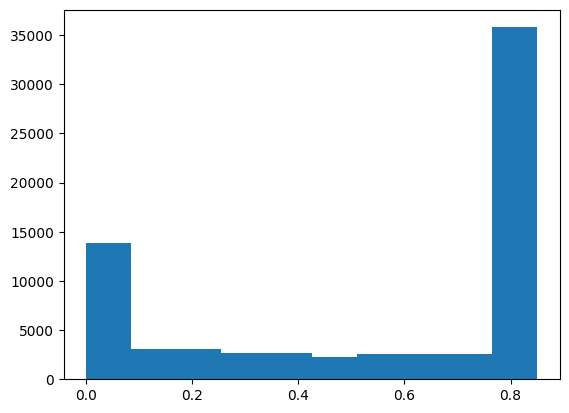

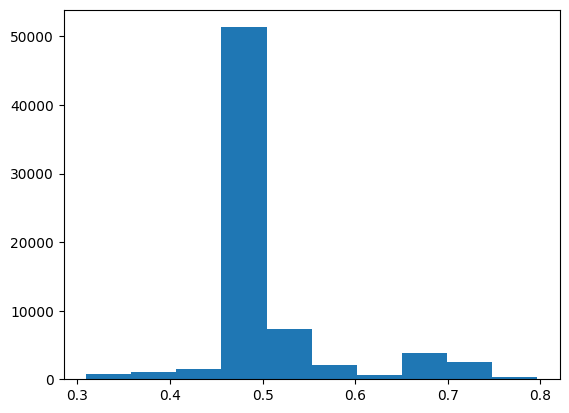

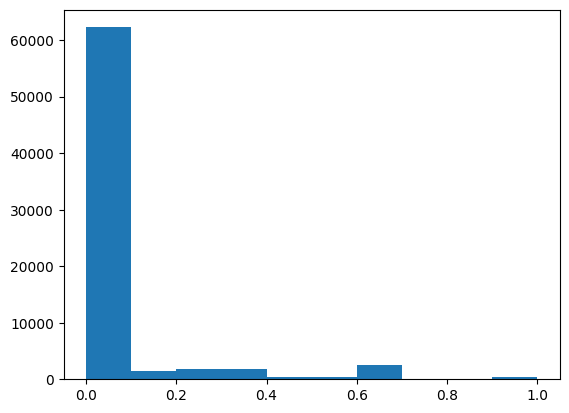

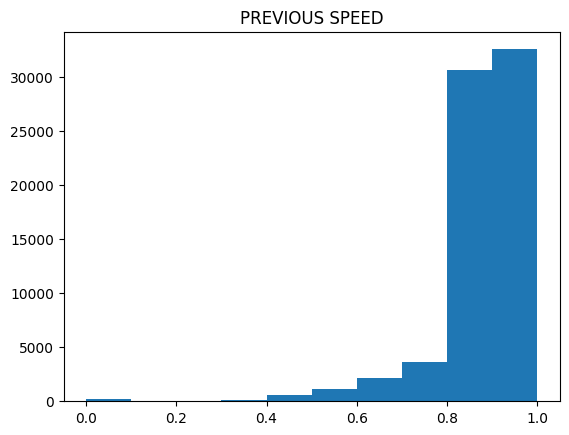

71224


In [10]:
print('--- CARLA dataset ---')
ann_x = []
ann_y = []
ann_z = []
ann_vel = []

for ann in array_annotations_carla_dataset:   
    #print(ann)
    ann_x.append(ann[0])
    ann_y.append(round(ann[1], 4))
    ann_z.append(round(ann[2], 4))
    ann_vel.append(round(ann[3], 4))

n, bins, patches = plt.hist(x=ann_x)
plt.show()
n, bins, patches = plt.hist(x=ann_y)
plt.show()
n, bins, patches = plt.hist(x=ann_z)
plt.show()
n, bins, patches = plt.hist(x=ann_vel)
plt.title('PREVIOUS SPEED')
plt.show()
print(len(array_annotations_carla_dataset))

In [11]:
array_imgs = images_carla_dataset
array_annotations = array_annotations_carla_dataset

18173
71224


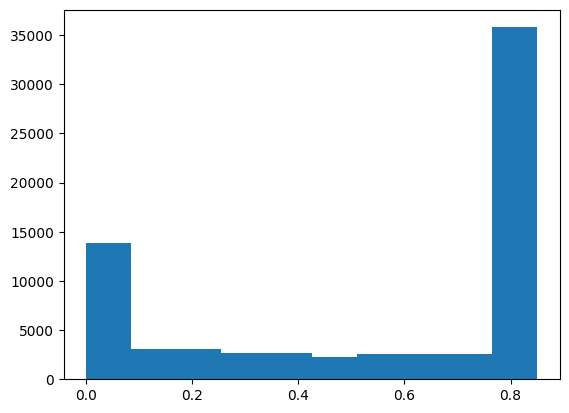

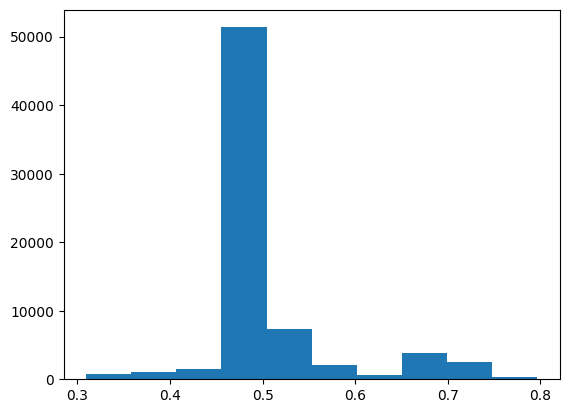

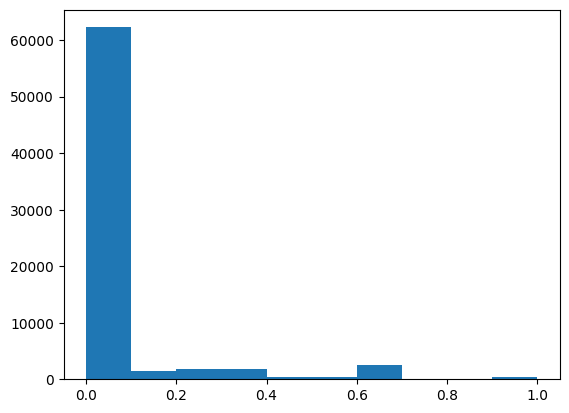

71224
71224


In [12]:
ann_x = []
ann_y = []
ann_z = []
number = 0 
total_number = 0
for x, ann in enumerate(array_annotations):
    ann_x.append(ann[0])
    ann_y.append(ann[1])
    ann_z.append(ann[2])
    if float(ann[0]) <= 0.2:
        number += 1
    total_number += 1
print(number)
print(total_number)

n, bins, patches = plt.hist(x=ann_x)
plt.show()
n, bins, patches = plt.hist(x=ann_y)
plt.show()
n, bins, patches = plt.hist(x=ann_z)
plt.show()


array_x = array_imgs
array_y = array_annotations

print(len(array_x))
print(len(array_y))

In [13]:
print(len(array_x))
print(len(array_y))
images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_x, array_y, test_size=0.30, random_state=42, shuffle=True)

print('Images train -> ' + str(len(images_train)))
print('Images validation -> ' + str(len(images_validation)))
print('Annotations train -> ' + str(len(annotations_train)))
print('Annotations validation -> ' + str(len(annotations_validation)))

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

print('Images train -> ' + str(images_train.shape))
print('Images validation -> ' + str(images_validation.shape))
print('Annotations train -> ' + str(annotations_train.shape))
print('Annotations validation -> ' + str(annotations_validation.shape))


71224
71224
Images train -> 49856
Images validation -> 21368
Annotations train -> 49856
Annotations validation -> 21368
Images train -> (49856, 150, 50, 3)
Images validation -> (21368, 150, 50, 3)
Annotations train -> (49856, 4)
Annotations validation -> (21368, 4)


[0.84904087 0.49991213 0.         0.92611073]
[0.85000002 0.4870075  0.         0.91526975]
[0.85000002 0.49969222 0.         0.58240077]
[0.85000002 0.45982624 0.         0.87889883]
[0.         0.51121414 0.03087297 0.95422197]
[0.85000002 0.5        0.         0.53379028]
[0.         0.50039565 0.23307684 0.9479039 ]
[0.27923781 0.5        0.         0.96176405]
[0.85000002 0.5001632  0.         0.8321714 ]
[0.85000002 0.66076836 0.         0.84323722]
[0.85000002 0.49930515 0.         0.84717115]


<Figure size 640x480 with 0 Axes>

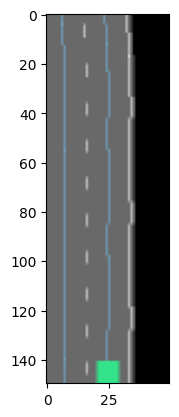

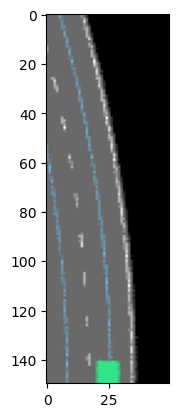

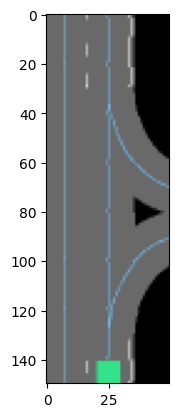

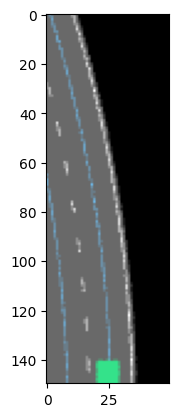

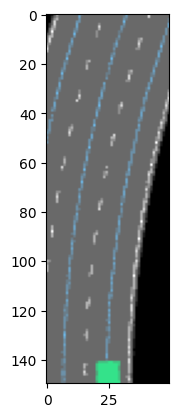

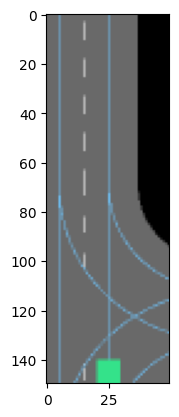

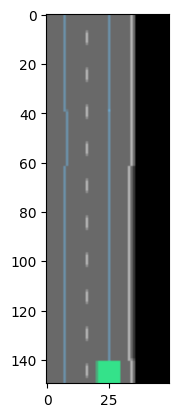

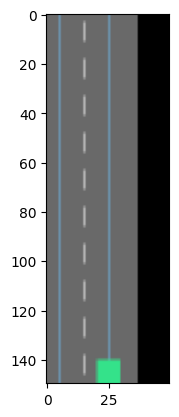

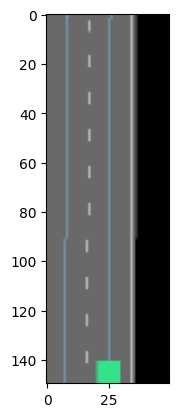

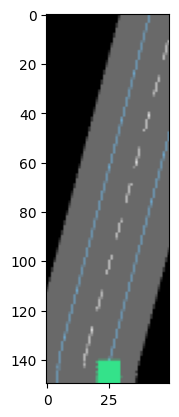

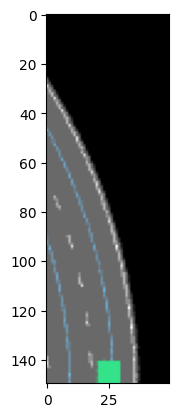

<Figure size 640x480 with 0 Axes>

In [14]:
for i in range(0,10):
    plt.imshow(images_validation[i])
    print(annotations_validation[i])
    plt.figure()
plt.imshow(images_validation[500])
print(annotations_validation[500])
plt.figure()

--- ANNOTATIONS DATA ---


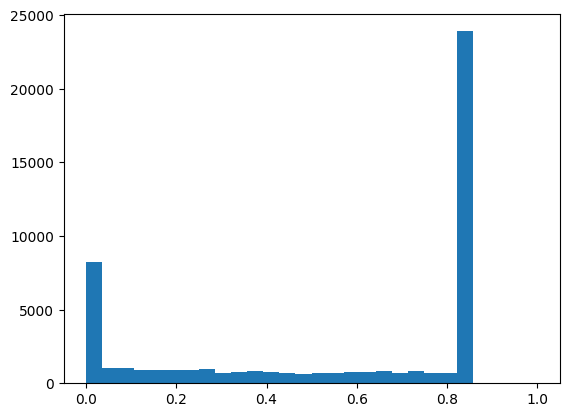

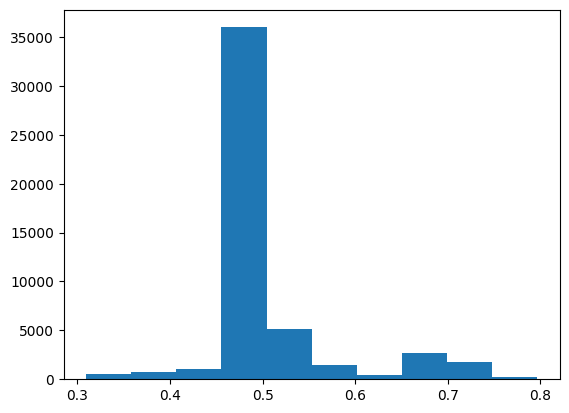

--- VALIDATION DATA ---


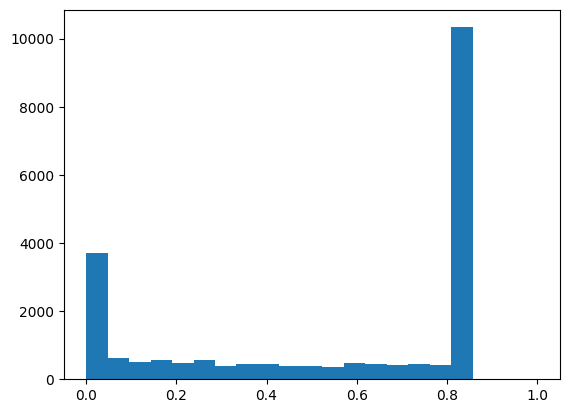

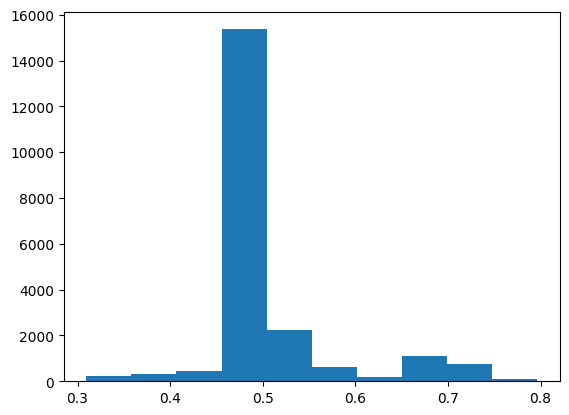

In [15]:
print('--- ANNOTATIONS DATA ---')
ann_x = []
ann_y = []
for ann in annotations_train:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto', range=[0, 1])
plt.show()
n, bins, patches = plt.hist(x=ann_y)
plt.show()

print('--- VALIDATION DATA ---')
ann_x = []
ann_y = []
for ann in annotations_validation:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto', range=[0, 1])
plt.show()
n, bins, patches = plt.hist(x=ann_y)
plt.show()

In [17]:
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize, ColorJitter, ChannelShuffle, Equalize, ReplayCompose, CoarseDropout,
    Affine
)

AUGMENTATIONS_TRAIN = ReplayCompose([
    Affine(p=0.5, rotate=0, translate_percent={'x':(-0.2, 0.2)}),
    RandomBrightnessContrast(),
    HueSaturationValue(),
    FancyPCA(),
    RandomGamma(),
    GaussianBlur(),
    Normalize()
])


AUGMENTATIONS_TEST = ReplayCompose([
    Normalize()
])

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Dropout, ConvLSTM2D, Reshape, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def deepest_lstm_tinypilotnet_model(img_shape):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), strides=(2, 2), input_shape=img_shape, activation="relu"))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Reshape((1, 17, 5, 8)))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=True))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=True))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=False))
    model.add(Flatten())
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(3))
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss="mse", metrics=['mse', 'mae'])
    return model

In [19]:
import tensorflow as tf
!echo $LD_LIBRARY_PATH
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/home/SergioPaniego/carla_simulator/.carla_env/lib/python3.8/site-packages/cv2/../../lib64:
Num GPUs Available:  2


In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger
import datetime

timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

img_shape = (150, 50, 4)

print(images_train.shape)
print(annotations_train.shape)

print(images_validation.shape)
print(annotations_validation.shape)


hparams = {
    'train_batch_size': 64, 
    'val_batch_size': 64,
    'batch_size': 64,
    'n_epochs': 300, 
    'checkpoint_dir': '../logs_test/'
}

print(hparams)

model_name = 'deepest_lstm_tinypilotnet_model'
model = deepest_lstm_tinypilotnet_model(img_shape)
model_filename = timestr + '_deepestLSTMTinyPilotNet_CARLA_17_10_dataset_bird_eye_300_epochs_no_flip_3_output_velocity_all_towns_vel_30_AFFINE_PAPER'
model_file = model_filename + '.h5'


# Training data
train_gen = DatasetSequenceAffine(images_train, annotations_train, hparams['batch_size'], augmentations=AUGMENTATIONS_TRAIN)
#train_gen = DatasetSequence(images_train, annotations_train, hparams['batch_size'], augmentations=AUGMENTATIONS_TRAIN)


# Validation data
valid_gen = DatasetSequence(images_validation, annotations_validation, hparams['batch_size'], augmentations=AUGMENTATIONS_TEST)


# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="mae", patience=30, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger(model_filename + '.csv', append=True)

# Print layers
print(model)
model.build(img_shape)
print(model.summary())
# Training
model.fit(
    train_gen,
    epochs=hparams['n_epochs'],
    verbose=2,
    validation_data=valid_gen,
    #workers=2, use_multiprocessing=False,
    callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)


# Evaluate the model
score = model.evaluate_generator(valid_gen, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = hparams['train_batch_size']
    f.attrs['nb_epoch'] = hparams['n_epochs']
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(annotations_train)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

# Continue training

In [ ]:
from tensorflow.keras.models import load_model
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger
import datetime

timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

img_shape = (66, 200, 3)
print(images_train.shape)
print(annotations_train.shape)

print(images_validation.shape)
print(annotations_validation.shape)


hparams = {
    'train_batch_size': 64, 
    'val_batch_size': 64,
    'batch_size': 64,
    'n_epochs': 100, 
    'checkpoint_dir': '../logs_test/'
}

print(hparams)

model = load_model('20221007-173344_pilotnet_CARLA_04_10_dataset_bird_eye_random_start_point_300_epochs_no_flip_3_output_more_more_data_retrained_cp.h5')

model_name = 'pilotnet_model'
#model = pilotnet_model(img_shape)
model_filename = timestr + '_pilotnet_CARLA_04_10_dataset_bird_eye_random_start_point_300_epochs_no_flip_3_output_more_more_data_retrained'
model_file = model_filename + '.h5'


# Training data
train_gen = DatasetSequence(images_train, annotations_train, hparams['batch_size'], augmentations=AUGMENTATIONS_TRAIN)

# Validation data
valid_gen = DatasetSequence(images_validation, annotations_validation, hparams['batch_size'], augmentations=AUGMENTATIONS_TEST)


# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="mae", patience=30, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger(model_filename + '.csv', append=True)

# Print layers
print(model)
model.build(img_shape)
print(model.summary())
# Training
model.fit(
    train_gen,
    epochs=hparams['n_epochs'],
    verbose=2,
    validation_data=valid_gen,
    #workers=2, use_multiprocessing=False,
    callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)


# Evaluate the model
score = model.evaluate_generator(valid_gen, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = hparams['train_batch_size']
    f.attrs['nb_epoch'] = hparams['n_epochs']
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(annotations_train)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

# Test model

In [8]:
import glob
import os
import cv2
import pandas

import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

image_shape=(200, 66)
image_shape=(50, 150)

def get_images(folder_prefix, list_images, type_image):
    # Read the images
    array_imgs = []
    for name in list_images:
        img = cv2.imread(folder_prefix + name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_shape)
        array_imgs.append(img)

    return array_imgs

def parse_csv(csv_data):
    array = []
    linear_speeds = csv_data['throttle'].tolist()
    angular_speeds = csv_data['steer'].tolist()
    brakes = csv_data['brake'].tolist()
    images_ids = csv_data['image_id'].tolist()
    velocity = csv_data['velocity'].tolist()
    timestamp = csv_data['timestamp'].tolist()
    for x, linear_speed in enumerate(linear_speeds):
        try:
            array.append((float(linear_speed), float(angular_speeds[x]), float(brakes[x]), float(velocity[x]), float(timestamp[x])))
        except:
            print('ERROR in value')
    return images_ids, array

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

def normalize_v(x):
    x = np.asarray(x)
    return (x - 0) / (np.ptp(x))

########################################################################################################################### 1 ###########################################################################################################################
print('---- CARLA dataset ----')
carla_dataset_name_file = 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/dataset.csv'
carla_dataset_file = open(carla_dataset_name_file, 'r')
data_carla_dataset = carla_dataset_file.read()
carla_dataset_file.close()

array_annotations_carla_dataset = []
DIR_carla_dataset_images = 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/'
list_images_carla_dataset = glob.glob(DIR_carla_dataset_images + '*')
new_list_images_carla_dataset = []
for image in list_images_carla_dataset:
    if image != 'Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/dataset.csv':
        new_list_images_carla_dataset.append(image)
list_images_carla_dataset = new_list_images_carla_dataset

images_paths_carla_dataset = sorted(list_images_carla_dataset, key=lambda x: int(x.split('/')[3].split('.png')[0]))

array_annotations_carla_dataset = pandas.read_csv(carla_dataset_name_file)
images_ids, array_annotations_carla_dataset = parse_csv(array_annotations_carla_dataset)


images_ids = images_ids[:20000]
array_annotations_carla_dataset = array_annotations_carla_dataset[:20000]

images_carla_dataset = get_images('Documentos/carla_dataset_previous_v/carla_dataset_test_31_10_anticlockwise_town_01_previous_v/', images_ids, 'cropped')
#images_carla_dataset, array_annotations_carla_dataset = flip_images(images_carla_dataset, array_annotations_carla_dataset)
print(len(images_carla_dataset))
print(type(images_carla_dataset))
print(len(array_annotations_carla_dataset))
#images_carla_dataset, array_annotations_carla_dataset = add_extreme_data(images_carla_dataset, array_annotations_carla_dataset)
print(len(images_carla_dataset))
print(type(images_carla_dataset))
print(len(array_annotations_carla_dataset))

array_annotations_v = []
array_annotations_w = []
array_annotations_b = []
array_annotations_vel = []
for annotation in array_annotations_carla_dataset:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    array_annotations_b.append(annotation[2])
    array_annotations_vel.append(annotation[3])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_Y = np.interp(array_annotations_w, (-1, 1), (0, 1))

array_annotations_b = np.stack(array_annotations_b, axis=0)
array_annotations_b = array_annotations_b.reshape(-1, 1)

print('MAX SPEED ->', max(array_annotations_vel))
array_annotations_vel = np.stack(array_annotations_vel, axis=0)
array_annotations_vel = array_annotations_vel.reshape(-1, 1)
#array_annotations_vel = np.interp(array_annotations_vel, (0, 88), (0, 1))
array_annotations_vel = np.interp(array_annotations_vel, (0, max(array_annotations_vel)), (0, 1))


normalized_annotations = []
for i in range(0, len(array_annotations_w)):
    normalized_annotations.append([array_annotations_v.item(i), normalized_Y.item(i), array_annotations_b.item(i), array_annotations_vel.item(i)])
 
    
array_annotations_carla_dataset = normalized_annotations
print(len(images_carla_dataset))
print(type(images_carla_dataset))
print(len(array_annotations_carla_dataset))
#print(array_annotations_carla_dataset)

---- CARLA dataset ----
6183
<class 'list'>
6183
6183
<class 'list'>
6183
MAX SPEED -> 31.57310445365421
6183
<class 'list'>
6183


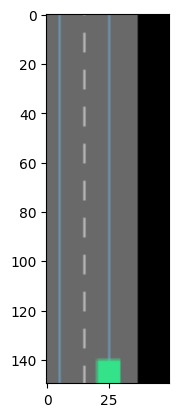

In [9]:
plt.imshow(images_carla_dataset[0])

In [10]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

194/194 [==============================] - 1s 3ms/step
[[ 0.5873612   0.46701384  0.01473539  0.0183859 ]
 [ 0.5196878   0.5045957   0.2539666   0.96399647]
 [ 0.8049833   0.5148453   0.03776364  0.91506535]
 ...
 [ 0.44108224  0.50050426  0.30000314  0.96103126]
 [ 0.8122396   0.5113224   0.02868476  0.8507081 ]
 [ 0.96491385  0.54288065 -0.09373396  0.87401885]]


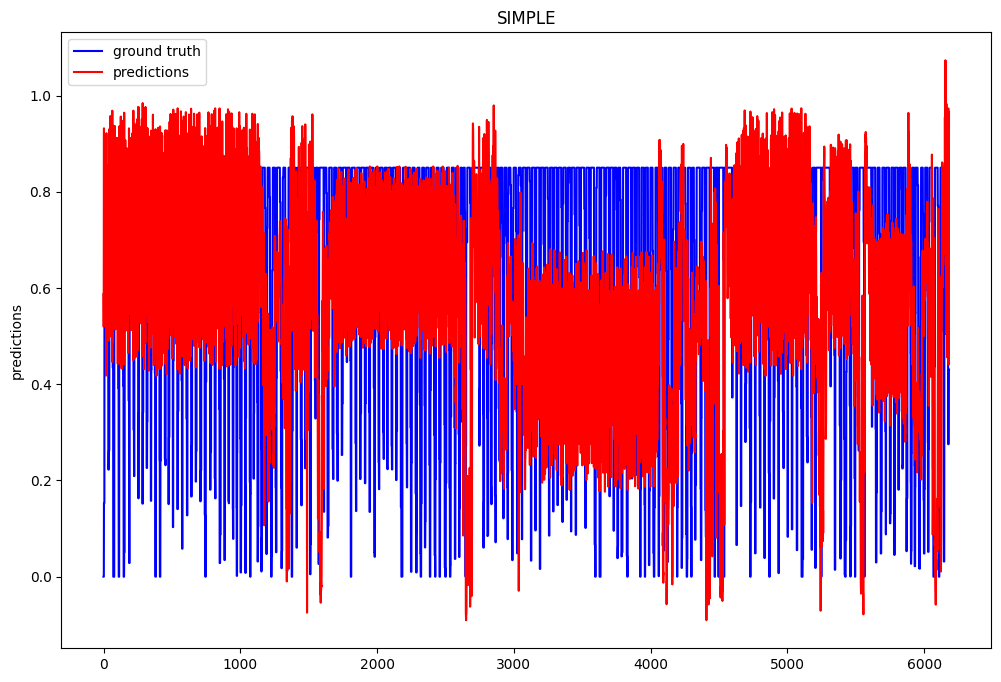

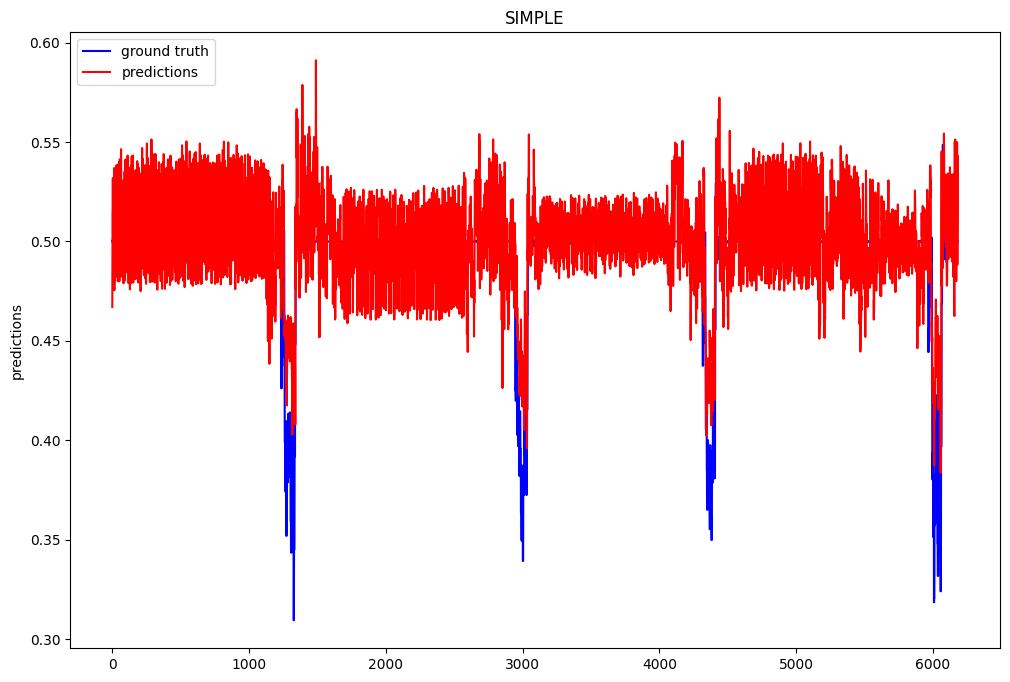

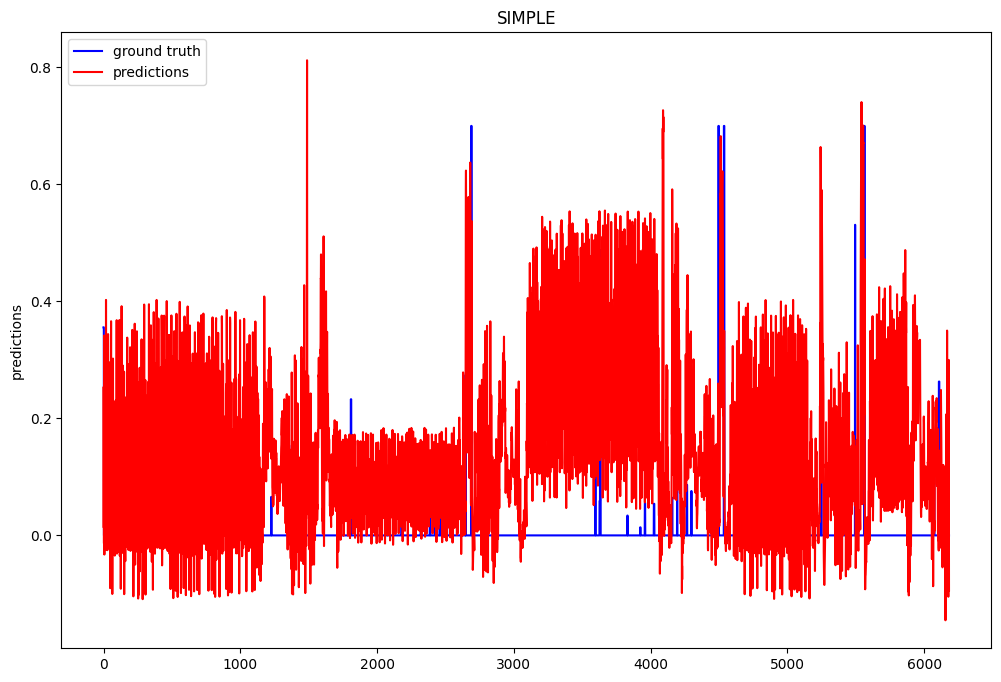

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize
)

model = load_model('20221104-143528_pilotnet_CARLA_17_10_dataset_bird_eye_300_epochs_no_flip_3_output_velocity_all_towns_vel_30_cp.h5')

model = load_model('20221108-155441_pilotnet_CARLA_17_10_dataset_bird_eye_300_epochs_no_flip_3_input_output_velocity_town_01_and_extreme_vel_MAX_cp.h5')

AUGMENTATIONS_TEST = Compose([
    Normalize()
])

normalized_images = []
for x, img in enumerate(images_carla_dataset):
    #print(batch_y[x])
    image = AUGMENTATIONS_TEST(image=img)['image']
    velocity_dim = np.full((150, 50), array_annotations_carla_dataset[x][3])
    new_img_vel = np.dstack((image, velocity_dim))
    normalized_images.append(new_img_vel)

normalized_images = np.stack(normalized_images, axis=0)
predictions_train = model.predict(normalized_images)

print(predictions_train)

array_annotations_carla_dataset = np.stack(array_annotations_carla_dataset, axis=0)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(array_annotations_carla_dataset[:,0], "-b", label="ground truth")
plt.plot(predictions_train[:,0], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('SIMPLE')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(array_annotations_carla_dataset[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('SIMPLE')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(array_annotations_carla_dataset[:,2], "-b", label="ground truth")
plt.plot(predictions_train[:,2], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('SIMPLE')
plt.show()

In [12]:
A = np.stack(array_annotations_carla_dataset, axis=0)
print('++++++')
print(A)
print('++++++')
B = predictions_train
print(B)
print('++++++')
mse = ((A[:,0] - B[:,0])**2).mean()
print(mse)
mse = ((A[:,1] - B[:,1])**2).mean()
print(mse)
mse = ((A[:,2] - B[:,2])**2).mean()
print(mse)

++++++
[[0.         0.5003809  0.35571629 0.        ]
 [0.         0.5003809  0.35571629 0.9784087 ]
 [0.         0.5003809  0.35571629 0.96578932]
 ...
 [0.43048218 0.50012426 0.         0.9636051 ]
 [0.43048218 0.50012426 0.         0.85966365]
 [0.43048218 0.50012426 0.         0.85063389]]
++++++
[[ 0.5873612   0.46701384  0.01473539  0.0183859 ]
 [ 0.5196878   0.5045957   0.2539666   0.96399647]
 [ 0.8049833   0.5148453   0.03776364  0.91506535]
 ...
 [ 0.44108224  0.50050426  0.30000314  0.96103126]
 [ 0.8122396   0.5113224   0.02868476  0.8507081 ]
 [ 0.96491385  0.54288065 -0.09373396  0.87401885]]
++++++
0.1264044554186912
0.000527694728991629
0.03798755118626298


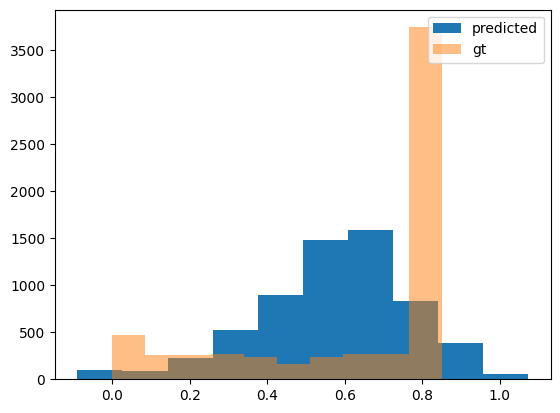

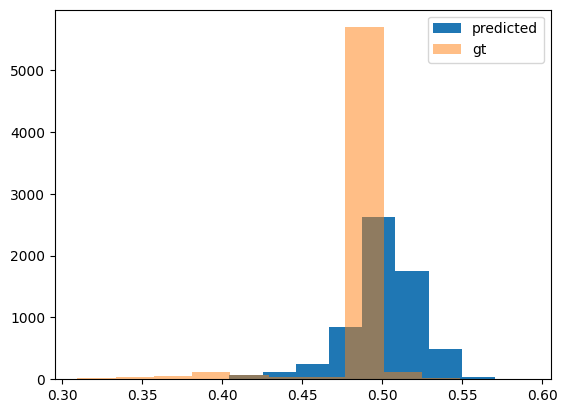

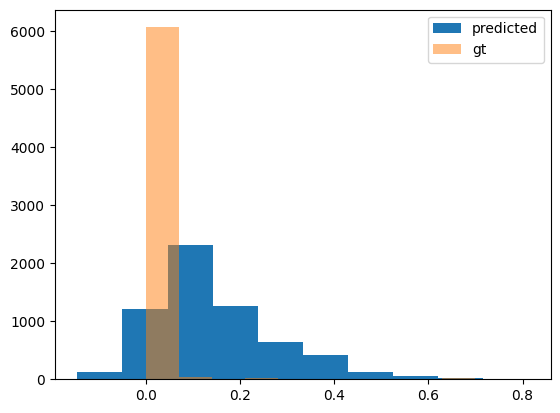

In [13]:
ann_x = []
ann_y = []
ann_z = []
for x, ann in enumerate(array_annotations_carla_dataset):
    ann_x.append(ann[0])
    ann_y.append(ann[1])
    ann_z.append(ann[2])


predictions_ann_x = []
predictions_ann_y = []
predictions_ann_z = []
number = 0 
total_number = 0
for x, ann in enumerate(predictions_train):
    predictions_ann_x.append(ann[0])
    predictions_ann_y.append(ann[1])
    predictions_ann_z.append(ann[2])

plt.hist(x=predictions_ann_x, label='predicted')
plt.hist(ann_x, alpha=0.5, label='gt')
plt.legend(loc='upper right')
plt.show()

plt.hist(x=predictions_ann_y, label='predicted')
plt.hist(ann_y, alpha=0.5, label='gt')
plt.legend(loc='upper right')
plt.show()

plt.hist(x=predictions_ann_z, label='predicted')
plt.hist(ann_z, alpha=0.5, label='gt')
plt.legend(loc='upper right')
plt.show()